# Step 1: Prep
Run this section only once to move the files over from your drive. This will setup the environment needed to run the pipeline.

- Move the files to your personal Drive
  - trainxs.zip
  - annotations/train.json.
- Location of the files:
https://drive.google.com/drive/folders/1ES3tEWHM2VKRNEeBI_XKR1sHioi3aRTY?usp=sharing

In [1]:
 #@title Install missing pip package
 !pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.4 MB/s eta 0:00:00


In [2]:
#@title Move data from Google Drive and unzip.
import os
import shutil
import time
from google.colab import drive

# ==========================================
# 1. MOUNT DRIVE (The "Vault")
# ==========================================
# This gives access to your permanent storage
drive.mount('/content/drive')

# Paths
# Get the trainxs.zip and annotations/train.json from:
# https://drive.google.com/drive/folders/1ES3tEWHM2VKRNEeBI_XKR1sHioi3aRTY?usp=sharing
DRIVE_BASE_PATH = '/content/drive/MyDrive'
DRIVE_ZIP_PATH = DRIVE_BASE_PATH + '/Oxford/study/VIS/phase_1/trainxs.zip'
DRIVE_ANNOTATION_PATH = DRIVE_BASE_PATH + '/Oxford/study/VIS/phase_1/annotations/train.json'
# Local storage in colab
LOCAL_ZIP_PATH = '/content/trainxs.zip'
LOCAL_DATA_DIR = '/content/data_local'
LOCAL_ANNOTATION_PATH = '/content/train.json'

# ==========================================
# 2. COPY & UNZIP (The Speed Hack)
# ==========================================

shutil.copy(DRIVE_ANNOTATION_PATH, LOCAL_ANNOTATION_PATH)

if not os.path.exists(LOCAL_DATA_DIR):
    print("🚀 Copying data from Drive to Local SSD (Fast)...")
    t0 = time.time()

    # Copy the ZIP from Drive to Colab Local Disk
    shutil.copy(DRIVE_ZIP_PATH, LOCAL_ZIP_PATH)

    print(f"📦 Unzipping... (This is fast on Colab SSD)")
    # Unzip quietly (-q) to avoiding spamming output
    os.system(f'unzip -q {LOCAL_ZIP_PATH} -d {LOCAL_DATA_DIR}')

    t1 = time.time()
    print(f"✅ Data Ready! Setup took: {t1-t0:.2f}s")
else:
    print("✅ Data already loaded locally.")

# ==========================================
# 3. CONFIGURE YOUR STRATEGY
# ==========================================
# Point your existing code to look at the LOCAL folder, not Drive
TRAIN_DIR = os.path.join(LOCAL_DATA_DIR, 'trainxs')
# (Make sure this matches the folder structure inside your zip)

Mounted at /content/drive
🚀 Copying data from Drive to Local SSD (Fast)...
📦 Unzipping... (This is fast on Colab SSD)
✅ Data Ready! Setup took: 79.83s


# Step 2: Run the Pipeline (Different versions)

In [ ]:
#@title Baseline strategy logic
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import glob
import torch
import torchvision
import cv2
import json
import sys
import pandas as pd
import warnings
import math
from collections import defaultdict
import re
import datetime

warnings.simplefilter(action='ignore', category=FutureWarning)

# ==========================================
# 2. CONFIGURATION
# ==========================================
MODEL_NAME = 'yolov5n'
IMG_SIZE = 1280
CONF_THRESH = 0.01
IOU_THRESH = 0.45

SHOULD_LIMIT_VIDEO = 1 # Number of videos to run this pipeline (up to the index or all of the videos)
VIDEO_INDEXES = [1] # if SHOULD_LIMIT_VIDEO == 1 then use the following to grab exact indexes of videos to process.
model_classes = [14] # # Which classes to detect. Only Birds
IS_GPU_ALLOWED = False # Speed up development by using GPU for baseline.
OUTPUT_CSV_PATH = f'./baseline_tiled_{'gpu' if IS_GPU_ALLOWED else 'cpu'}.csv' # Final output CSV

print(f"\n🚀 CHECKING DATA...")

# A. Check Annotations
if not os.path.exists(LOCAL_ANNOTATION_PATH):
    print(f"⬇️ 'train.json' not found")
    if os.path.exists(DRIVE_ANNOTATION_PATH):
        print(f"⬇️ 'train.json' Downloading...")
        shutil.copy(DRIVE_ANNOTATION_PATH, LOCAL_ANNOTATION_PATH)
else:
    print("✅ Annotations found locally.")

# B. Check Video Data
if os.path.exists(TRAIN_DIR) and len(os.listdir(TRAIN_DIR)) > 0:
    print(f"✅ Training data found in '{TRAIN_DIR}'. Skipping download.")
else:
    print(f"⬇️ Data not found. Downloading from Drive...")
    t0 = time.time()
    shutil.copy(DRIVE_ZIP_PATH, LOCAL_ZIP_PATH)
    print(f"📦 Unzipping... (This is fast on Colab SSD)")
    os.system(f'unzip -q {LOCAL_ZIP_PATH} -d {LOCAL_DATA_DIR}')
    t1 = time.time()
    print(f"✅ Data Ready! Setup took: {t1-t0:.2f}s")

print(f"⏳ Loading Model: {MODEL_NAME}...")
try:
    model = torch.hub.load('ultralytics/yolov5', MODEL_NAME, pretrained=True, force_reload=False)
    model.conf = CONF_THRESH
    model.classes = model_classes

    if torch.cuda.is_available() and IS_GPU_ALLOWED:
        device = torch.device('cuda')
        print("✅ Model Loaded on GPU.")
    else:
        device = torch.device('cpu')
        print("⚠️ Model Loaded on CPU.")

    model.to(device)
except Exception as e:
    print(f"❌ Model Load Error: {e}")

# ==========================================
# 3. HELPER FUNCTIONS
# ==========================================
def load_json_ground_truth(json_path):
    if not os.path.exists(json_path): return {}
    print(f"📂 Parsing annotations from: {json_path}...")
    try:
        with open(json_path, 'r') as f: data = json.load(f)
    except Exception as e:
        print(f"❌ JSON Parse Error: {e}")
        return {}

    id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    img_id_to_boxes = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            img_id_to_boxes[ann['image_id']].append(ann['bbox'])

    filename_to_gt = {}
    for img_id, filename in id_to_filename.items():
        key = filename.replace('train/', '', 1) if filename.startswith('train/') else filename
        filename_to_gt[key] = img_id_to_boxes.get(img_id, [])

    print(f"✅ Loaded GT for {len(filename_to_gt)} images.")
    return filename_to_gt

def get_center(box):
    return (box[0] + box[2]/2, box[1] + box[3]/2)

def calculate_center_distance(box1, box2):
    c1 = get_center(box1)
    c2 = get_center(box2)
    return math.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)

def get_next_version_path(path):
    if not os.path.exists(path): return path
    directory, filename = os.path.split(path)
    name, ext = os.path.splitext(filename)
    if directory and not os.path.exists(directory): os.makedirs(directory)
    pattern = re.compile(rf"^{re.escape(name)}_(\d+){re.escape(ext)}$")
    max_version = 0
    for f in os.listdir(directory if directory else '.'):
        match = pattern.match(f)
        if match:
            version = int(match.group(1))
            if version > max_version: max_version = version
    return os.path.join(directory, f"{name}_{max_version + 1}{ext}")

# ==========================================
# 4. TILING LOGIC (Optimized 4x3 Grid)
# ==========================================
def get_tiled_predictions(model, img, img_size, device):
    """
    Splits image into a 4x3 Grid (12 tiles).
    Optimization: Sends all 12 tiles to GPU in ONE BATCH to use full VRAM.
    """
    h, w, _ = img.shape

    # Grid Configuration: 4 Cols x 3 Rows = 12 Tiles
    N_COLS = 4
    N_ROWS = 3

    h_step = h // N_ROWS
    w_step = w // N_COLS
    h_over = int(h_step * 0.20)
    w_over = int(w_step * 0.20)

    crops = []
    offsets = []

    for r in range(N_ROWS):
        for c in range(N_COLS):
            y1 = max(0, r * h_step - h_over)
            x1 = max(0, c * w_step - w_over)
            y2 = min(h, (r + 1) * h_step + h_over)
            x2 = min(w, (c + 1) * w_step + w_over)

            crops.append(img[y1:y2, x1:x2])
            offsets.append((x1, y1))

    # Batch Inference
    all_boxes = []
    all_scores = []

    # OPTIMIZATION: Process ALL 12 tiles in one massive batch
    # Your GPU has 15GB, this will use ~6-8GB. Perfect fit.
    CHUNK_SIZE = 12

    for i in range(0, len(crops), CHUNK_SIZE):
        sub_crops = crops[i : i + CHUNK_SIZE]
        sub_offsets = offsets[i : i + CHUNK_SIZE]

        results = model(sub_crops, size=img_size)

        for j, det in enumerate(results.xyxy):
            if det is not None and len(det) > 0:
                det = det.clone()
                x_off, y_off = sub_offsets[j]
                det[:, 0] += x_off
                det[:, 1] += y_off
                det[:, 2] += x_off
                det[:, 3] += y_off
                all_boxes.append(det[:, :4])
                all_scores.append(det[:, 4])

    if not all_boxes: return []

    pred_boxes = torch.cat(all_boxes, dim=0)
    pred_scores = torch.cat(all_scores, dim=0)
    keep_indices = torchvision.ops.nms(pred_boxes, pred_scores, iou_threshold=0.45)
    final_tensor = pred_boxes[keep_indices]

    final_preds = []
    final_tensor = final_tensor.cpu().numpy()
    for box in final_tensor:
        x1, y1, x2, y2 = box
        final_preds.append([x1, y1, x2-x1, y2-y1])

    return final_preds

# ==========================================
# 5. OPTIMIZED BATCHED PIPELINE
# ==========================================
def run_baseline_evaluation():
    gt_data = load_json_ground_truth(LOCAL_ANNOTATION_PATH)
    if not gt_data: return

    start_time = time.time()

    # Select the videos that will be processed based on config.
    video_folders = sorted(glob.glob(os.path.join(TRAIN_DIR, '*')))
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    if SHOULD_LIMIT_VIDEO:
      if SHOULD_LIMIT_VIDEO == 1:
        new_video_folders = []
        for ind in VIDEO_INDEXES:
          new_video_folders.append(video_folders[ind])
        video_folders = new_video_folders
      else:
        video_folders = video_folders[:min(len(video_folders),SHOULD_LIMIT_VIDEO)]

    if not video_folders:
        print(f"❌ No video folders found in {TRAIN_DIR}.")
        return

    print(f"📂 Found {len(video_folders)} videos. Starting Batched Inference (4x3 Tiling)...")

    total_tp = total_fp = total_fn = total_time_sec = total_frames = 0
    results_data = []

    print(f"\n{'Video':<10} | {'Frames':<6} | {'FPS':<6} | {'Prec':<6} | {'Recall':<6} | {'F1':<6} | {'Time':<6}")
    print("-" * 65)

    for v_idx, video_path in enumerate(video_folders):
        video_name = os.path.basename(video_path)
        images = sorted(glob.glob(os.path.join(video_path, '*.jpg')))
        if not images: continue

        vid_tp = vid_fp = vid_fn = 0
        vid_start = time.time()
        n_frames = len(images)

        for i, img_path in enumerate(images):
            if i % 20 == 0:
                percent = ((i + 1) / n_frames) * 100
                sys.stdout.write(f"\r👉 Processing [{video_name}] Frame {i+1}/{n_frames} ({percent:.1f}%)")
                sys.stdout.flush()

            img = cv2.imread(img_path)
            if img is None: continue

            preds = get_tiled_predictions(model, img, IMG_SIZE, device)

            img_filename = os.path.basename(img_path)
            key = f"{video_name}/{img_filename}"
            gts = gt_data.get(key, [])

            matched_gt = set()
            for p_box in preds:
                best_dist = 10000
                best_idx = -1
                for g_idx, g_box in enumerate(gts):
                    if g_idx in matched_gt: continue
                    d = calculate_center_distance(p_box, g_box)
                    if d < best_dist:
                        best_dist = d
                        best_idx = g_idx

                if best_dist <= 30:
                    vid_tp += 1
                    matched_gt.add(best_idx)
                else:
                    vid_fp += 1
            vid_fn += len(gts) - len(matched_gt)

        vid_end = time.time()
        vid_time = vid_end - vid_start
        vid_fps = n_frames / vid_time if vid_time > 0 else 0

        total_time_sec += vid_time
        total_frames += n_frames
        total_tp += vid_tp; total_fp += vid_fp; total_fn += vid_fn

        prec = vid_tp / (vid_tp + vid_fp) if (vid_tp + vid_fp) > 0 else 0
        rec = vid_tp / (vid_tp + vid_fn) if (vid_tp + vid_fn) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

        sys.stdout.write("\r" + " " * 80 + "\r")
        print(f"{video_name:<10} | {n_frames:<6} | {vid_fps:<6.1f} | {prec:<6.2f} | {rec:<6.2f} | {f1:<6.2f} | {str(datetime.timedelta(seconds=int(vid_time)))}")

        results_data.append({
            'Video': video_name, 'Frames': n_frames, 'FPS': round(vid_fps, 2),
            'Precision': round(prec, 4), 'Recall': round(rec, 4), 'F1': round(f1, 4),
            'TP': vid_tp, 'FP': vid_fp, 'FN': vid_fn, 'Video_Time': vid_time
        })

    print("=" * 65)
    avg_fps = total_frames / total_time_sec if total_time_sec > 0 else 0
    overall_prec = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    overall_rec = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    overall_f1 = 2 * (overall_prec * overall_rec) / (overall_prec + overall_rec) if (overall_prec + overall_rec) > 0 else 0

    print("FINAL RESULTS (Baseline):")
    print(f"Total Frames:   {total_frames}")
    print(f"Average FPS:    {avg_fps:.2f}")
    print(f"Precision:      {overall_prec:.4f}")
    print(f"Recall:         {overall_rec:.4f}")
    print(f"F1-Score:       {overall_f1:.4f}")
    print("=" * 65)

    df = pd.DataFrame(results_data)
    final_path = get_next_version_path(OUTPUT_CSV_PATH)
    df.to_csv(final_path, index=False)
    print(f"✅ CSV Saved: {final_path}")
    print(f"⏱️ Process took: {str(datetime.timedelta(seconds=int(time.time() - start_time)))}")

if __name__ == "__main__":
    run_baseline_evaluation()


🚀 CHECKING DATA...
✅ Annotations found locally.
✅ Training data found in '/content/data_local/trainxs'. Skipping download.
⏳ Loading Model: yolov5n...


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-12-26 Python-3.12.12 torch-2.9.0+cpu CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Adding AutoShape... 


⚠️ Model Loaded on CPU.
📂 Parsing annotations from: /content/train.json...
✅ Loaded GT for 52680 images.
📂 Found 1 videos. Starting Batched Inference (4x3 Tiling)...

Video      | Frames | FPS    | Prec   | Recall | F1     | Time  
-----------------------------------------------------------------
👉 Processing [0002] Frame 361/597 (60.5%)

In [4]:
#@title Strat 7 Main strategy logic
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import glob
import cv2
import json
import sys
import pandas as pd
import numpy as np
import warnings
import math
from collections import defaultdict
import re
import datetime

warnings.simplefilter(action='ignore', category=FutureWarning)

# ==========================================
# 1.1. Config
# ==========================================
OUTPUT_CSV_PATH = './strat_7_cpu.csv'
USE_STRAT7_VERIFIER = True

# Tuning knobs (start here)
STRAT7_CROP_SCALE = 4.0      # expand each proposal box to include context
STRAT7_BIRD_THR = 0.01       # keep if birdness >= this
STRAT7_MIN_KEEP = 2          # keep at least this many per frame (helps recall)
STRAT7_MAX_KEEP = 5          # after filtering, cap again (optional)

SHOULD_LIMIT_VIDEO = 1 # Number of videos to run this pipeline (up to the index or all of the videos)
VIDEO_INDEXES = [1] # if SHOULD_LIMIT_VIDEO == 1 then use the following to grab exact indexes of videos to process.
model_classes = [14] # # Which classes to detect. Only Birds
IS_GPU_ALLOWED = False # Speed up development by using GPU for baseline.

try:
    import torch
    import torchvision
    from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
except Exception as e:
    raise RuntimeError(
        "Strat7 needs torch+torchvision. "
        "In Colab run: !pip -q install torch torchvision --extra-index-url https://download.pytorch.org/whl/cpu"
    ) from e

# Load model once
_STRAT7_WEIGHTS = MobileNet_V3_Small_Weights.DEFAULT
_strat7_model = mobilenet_v3_small(weights=_STRAT7_WEIGHTS).eval()
_strat7_model.to("cpu")
torch.set_num_threads(4)  # optional: tune for Colab CPU
_strat7_preprocess = _STRAT7_WEIGHTS.transforms()
_strat7_categories = _STRAT7_WEIGHTS.meta["categories"]

# Build a list of ImageNet class indices that are "bird-like"
# (Heuristic: match common bird words)
_bird_keywords = {
    "bird","sparrow","finch","warbler","oriole","blackbird","robin","jay","magpie",
    "eagle","hawk","falcon","vulture","owl","woodpecker","kingfisher","hummingbird",
    "parrot","macaw","cockatoo","lorikeet","peacock","crane","heron","stork","flamingo",
    "pelican","gull","tern","albatross","duck","goose","swan","chicken","hen","cock",
    "rooster","turkey","ptarmigan","partridge","quail","ostrich","emu","kiwi"
}
_exclude = {"kite"}  # avoid toy "kite"
_strat7_bird_indices = [
    i for i, name in enumerate(_strat7_categories)
    if (any(k in name.lower() for k in _bird_keywords) and not any(x in name.lower() for x in _exclude))
]

if len(_strat7_bird_indices) == 0:
    print("⚠️ Strat7: bird index list is empty. Birdness scoring may not work well.")

# ==========================================
# 2. AUTHENTICATION & DATA VERIFICATION
# ==========================================
print(f"\n🚀 CHECKING DATA...")

# A. Check Annotations
if not os.path.exists(LOCAL_ANNOTATION_PATH):
    print(f"⬇️ 'train.json' not found")
    if os.path.exists(DRIVE_ANNOTATION_PATH):
        print(f"⬇️ 'train.json' Downloading...")
        shutil.copy(DRIVE_ANNOTATION_PATH, LOCAL_ANNOTATION_PATH)
else:
    print("✅ Annotations found locally.")

# B. Check Video Data
if os.path.exists(TRAIN_DIR) and len(os.listdir(TRAIN_DIR)) > 0:
    print(f"✅ Training data found in '{TRAIN_DIR}'. Skipping download.")
else:
    print(f"⬇️ Data not found. Downloading from Drive...")
    t0 = time.time()
    shutil.copy(DRIVE_ZIP_PATH, LOCAL_ZIP_PATH)
    print(f"📦 Unzipping... (This is fast on Colab SSD)")
    os.system(f'unzip -q {LOCAL_ZIP_PATH} -d {LOCAL_DATA_DIR}')
    t1 = time.time()
    print(f"✅ Data Ready! Setup took: {t1-t0:.2f}s")

# ==========================================
# 3. MOTION COMPENSATION LOGIC (CPU)
# ==========================================
def align_frames(prev_gray, curr_gray):
    """
    Calculates camera motion and warps prev_gray to match curr_gray.
    """
    # 1. Detect Features
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=200, qualityLevel=0.01, minDistance=30)
    if prev_pts is None: return None

    # 2. Optical Flow
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)
    good_prev = prev_pts[status == 1]
    good_curr = curr_pts[status == 1]

    if len(good_prev) < 4: return None

    # 3. Find Homography
    H, mask = cv2.findHomography(good_prev, good_curr, cv2.RANSAC, 5.0)
    if H is None: return None

    # 4. Warp
    height, width = prev_gray.shape
    warped_prev = cv2.warpPerspective(prev_gray, H, (width, height))
    return warped_prev

# ==========================================
# 4. HELPER FUNCTIONS (TRACKING & METRICS)
# ==========================================
class ObjectTracker:
    def __init__(self, dist_thresh=50, max_frames_to_skip=5, min_hits=3):
        self.tracks = []
        self.track_id_count = 0
        self.dist_thresh = dist_thresh
        self.max_frames_to_skip = max_frames_to_skip
        self.min_hits = min_hits

    def update(self, detections):
        if len(self.tracks) == 0:
            for det in detections:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1
            return []

        assigned_dets = set()
        for track in self.tracks:
            best_dist = self.dist_thresh
            best_det_idx = -1
            # Euclidean distance center-to-center
            cx_t, cy_t = track['box'][0]+track['box'][2]/2, track['box'][1]+track['box'][3]/2

            for i, det in enumerate(detections):
                if i in assigned_dets: continue
                cx_d, cy_d = det[0]+det[2]/2, det[1]+det[3]/2
                d = ((cx_t-cx_d)**2 + (cy_t-cy_d)**2)**0.5
                if d < best_dist:
                    best_dist = d
                    best_det_idx = i

            if best_det_idx != -1:
                track['box'] = detections[best_det_idx]
                track['hits'] += 1
                track['skipped'] = 0
                assigned_dets.add(best_det_idx)
            else:
                track['skipped'] += 1

        for i, det in enumerate(detections):
            if i not in assigned_dets:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1

        self.tracks = [t for t in self.tracks if t['skipped'] <= self.max_frames_to_skip]
        return [t['box'] for t in self.tracks if t['hits'] >= self.min_hits]

def load_json_ground_truth(json_path):
    if not os.path.exists(json_path): return {}
    with open(json_path, 'r') as f: data = json.load(f)
    id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    img_id_to_boxes = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            img_id_to_boxes[ann['image_id']].append(ann['bbox'])
    filename_to_gt = {}
    for img_id, filename in id_to_filename.items():
        key = filename.replace('train/', '', 1) if filename.startswith('train/') else filename
        filename_to_gt[key] = img_id_to_boxes.get(img_id, [])
    return filename_to_gt

def get_center(box):
    return (box[0] + box[2]/2, box[1] + box[3]/2)

def calculate_center_distance(box1, box2):
    c1 = get_center(box1)
    c2 = get_center(box2)
    return math.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)

def get_next_version_path(path):
    if not os.path.exists(path): return path
    directory, filename = os.path.split(path)
    name, ext = os.path.splitext(filename)
    if directory and not os.path.exists(directory): os.makedirs(directory)
    pattern = re.compile(rf"^{re.escape(name)}_(\d+){re.escape(ext)}$")
    max_version = 0
    for f in os.listdir(directory if directory else '.'):
        match = pattern.match(f)
        if match:
            version = int(match.group(1))
            if version > max_version: max_version = version
    return os.path.join(directory, f"{name}_{max_version + 1}{ext}")

def box_iou_xywh(a, b):
    ax1, ay1, aw, ah = a
    bx1, by1, bw, bh = b
    ax2, ay2 = ax1 + aw, ay1 + ah
    bx2, by2 = bx1 + bw, by1 + bh

    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
    inter = iw * ih
    union = aw * ah + bw * bh - inter + 1e-6
    return inter / union

def nms_xywh(boxes, scores, iou_thr=0.3):
    if len(boxes) == 0:
        return []
    idxs = np.argsort(scores)[::-1]
    keep = []
    while len(idxs) > 0:
        i = idxs[0]
        keep.append(i)
        rest = idxs[1:]
        new_rest = []
        for j in rest:
            if box_iou_xywh(boxes[i], boxes[j]) < iou_thr:
                new_rest.append(j)
        idxs = np.array(new_rest, dtype=np.int64)
    return keep

# ==========================================
# 5. STRAT7: OFF-THE-SHELF CNN VERIFIER (CPU)
# ==========================================
def _expand_box_xywh(box, w_img, h_img, scale=2.0):
    x, y, w, h = box
    cx = x + w * 0.5
    cy = y + h * 0.5
    nw = w * scale
    nh = h * scale
    x0 = int(max(0, cx - nw * 0.5))
    y0 = int(max(0, cy - nh * 0.5))
    x1 = int(min(w_img, cx + nw * 0.5))
    y1 = int(min(h_img, cy + nh * 0.5))
    return x0, y0, x1, y1

@torch.inference_mode()
def strat7_birdness_scores(frame_bgr, boxes_xywh):
    """
    Returns a list of birdness scores (0..1) for each box.
    Uses MobileNetV3-Small ImageNet pretrained.
    """
    if len(boxes_xywh) == 0:
        return []

    h_img, w_img = frame_bgr.shape[:2]
    crops = []
    for box in boxes_xywh:
        x0, y0, x1, y1 = _expand_box_xywh(box, w_img, h_img, scale=STRAT7_CROP_SCALE)
        crop_bgr = frame_bgr[y0:y1, x0:x1]
        if crop_bgr.size == 0:
            # give a very low score if crop invalid
            crops.append(None)
            continue
        crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
        crops.append(crop_rgb)

    # Preprocess valid crops
    tensors = []
    valid_map = []  # maps tensor index -> original box index
    for i, c in enumerate(crops):
        if c is None:
            continue
        # torchvision transforms expects PIL or Tensor; easiest: convert to uint8 tensor
        c_tensor = torch.from_numpy(c).permute(2, 0, 1).contiguous()  # HWC->CHW
        tensors.append(_strat7_preprocess(c_tensor))
        valid_map.append(i)

    scores = [0.0] * len(boxes_xywh)
    if len(tensors) == 0:
        return scores

    batch = torch.stack(tensors, dim=0)
    logits = _strat7_model(batch)
    probs = torch.softmax(logits, dim=1)

    if len(_strat7_bird_indices) > 0:
        bird_probs = probs[:, _strat7_bird_indices].sum(dim=1)
    else:
        # fallback: use max prob as a weak confidence measure
        bird_probs = probs.max(dim=1).values

    bird_probs = bird_probs.cpu().numpy().tolist()
    for p, orig_idx in zip(bird_probs, valid_map):
        scores[orig_idx] = float(p)

    return scores

# ==========================================
# 6. MAIN PIPELINE
# ==========================================
def run_gmc_evaluation():
    gt_data = load_json_ground_truth(LOCAL_ANNOTATION_PATH)
    if not gt_data: return

    start_time = time.time()

    # Select the videos that will be processed based on config.
    video_folders = sorted(glob.glob(os.path.join(TRAIN_DIR, '*')))
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    if SHOULD_LIMIT_VIDEO:
      if SHOULD_LIMIT_VIDEO == 1:
        new_video_folders = []
        for ind in VIDEO_INDEXES:
          new_video_folders.append(video_folders[ind])
        video_folders = new_video_folders
      else:
        video_folders = video_folders[:min(len(video_folders),SHOULD_LIMIT_VIDEO)]

    if not video_folders:
        print(f"❌ No video folders found in {TRAIN_DIR}.")
        return

    print(f"📂 Found {len(video_folders)} videos. Starting...")

    total_tp = total_fp = total_fn = total_time = total_frames = 0
    results_data = []

    print(f"\n{'Video':<10} | {'Frames':<6} | {'FPS':<6} | {'Prec':<6} | {'Recall':<6} | {'F1':<6} | {'Time':<6}")
    print("-" * 65)

    for video_path in video_folders:
        video_name = os.path.basename(video_path)
        images = sorted(glob.glob(os.path.join(video_path, '*.jpg')))
        if not images: continue

        vid_tp = vid_fp = vid_fn = 0
        vid_start = time.time()
        n_frames = len(images)
        prev_gray = None
        tracker = ObjectTracker(dist_thresh=50, max_frames_to_skip=2, min_hits=2)

        for i, img_path in enumerate(images):
            if i % 50 == 0:
                percent = ((i + 1) / n_frames) * 100
                sys.stdout.write(f"\r👉 Processing [{video_name}] Frame {i+1}/{n_frames} ({percent:.1f}%)")
                sys.stdout.flush()

            frame = cv2.imread(img_path)
            if frame is None: continue
            curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            raw_detections = []

            if prev_gray is not None:
                warped_prev = align_frames(prev_gray, curr_gray)
                if warped_prev is not None:
                    # --- NEW LOGIC START ---

                    # 1) Difference after global motion compensation
                    diff = cv2.absdiff(curr_gray, warped_prev)

                    # 2) High-pass the diff to suppress low-frequency drift (helps tiny birds)
                    diff_f = diff.astype(np.float32)
                    diff_blur = cv2.GaussianBlur(diff_f, (0, 0), 2.0)
                    diff_hp = cv2.max(diff_f - diff_blur, 0).astype(np.uint8)

                    # 3) Hysteresis thresholds (HIGH-RECALL mode)
                    #    Lower these percentiles to increase TP/recall (at cost of FP).
                    t_low  = float(np.percentile(diff_hp, 98.5))   # try 98.5 / 99.0 / 99.3
                    t_high = float(np.percentile(diff_hp, 99.6))   # try 99.6 / 99.7 / 99.8
                    t_low  = max(8.0,  min(60.0, t_low))
                    t_high = max(15.0, min(85.0, t_high))

                    _, mask_low  = cv2.threshold(diff_hp, t_low,  255, cv2.THRESH_BINARY)
                    _, mask_high = cv2.threshold(diff_hp, t_high, 255, cv2.THRESH_BINARY)

                    # 4) Residual flow (supporting evidence; NOT a hard gate)
                    h_img, w_img = curr_gray.shape
                    scale = 0.33  # higher than 0.25 helps tiny motion show up
                    small_w = max(64, int(w_img * scale))
                    small_h = max(64, int(h_img * scale))
                    small_size = (small_w, small_h)

                    prev_s = cv2.resize(warped_prev, small_size, interpolation=cv2.INTER_AREA)
                    curr_s = cv2.resize(curr_gray,   small_size, interpolation=cv2.INTER_AREA)

                    flow = cv2.calcOpticalFlowFarneback(
                        prev_s, curr_s, None,
                        pyr_scale=0.5, levels=2, winsize=15,
                        iterations=2, poly_n=5, poly_sigma=1.2,
                        flags=0
                    )
                    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=False)

                    # Low percentile => more pixels considered "moving" => higher recall
                    t_mag = float(np.percentile(mag, 85))  # try 85 / 90 / 93
                    t_mag = max(0.20, t_mag)

                    flow_mask_s = (mag > t_mag).astype(np.uint8) * 255
                    flow_mask = cv2.resize(flow_mask_s, (w_img, h_img), interpolation=cv2.INTER_NEAREST)

                    # 5) DoG blob mask (catches tiny birds even when diff is weak)
                    g1 = cv2.GaussianBlur(curr_gray, (0, 0), 1.0)
                    g2 = cv2.GaussianBlur(curr_gray, (0, 0), 2.5)
                    dog = cv2.absdiff(g1, g2)

                    # Keep only strongest blob responses
                    t_dog = float(np.percentile(dog, 99.4))  # try 99.4 / 99.6 / 99.8
                    t_dog = max(10.0, min(60.0, t_dog))
                    _, dog_mask = cv2.threshold(dog, t_dog, 255, cv2.THRESH_BINARY)

                    # 6) Combine for high recall:
                    # - Always keep strong changes (mask_high)
                    # - Keep weak changes if supported by flow OR blob response
                    thresh = cv2.bitwise_or(
                        mask_high,
                        cv2.bitwise_and(mask_low, cv2.bitwise_or(flow_mask, dog_mask))
                    )

                    # 7) Morphology tuned to HELP recall:
                    #    - close to connect tiny fragments
                    #    - dilate to help pass your area>50 contour filter
                    k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
                    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, k3, iterations=1)
                    thresh = cv2.dilate(thresh, k3, iterations=2)

                    # --- NEW LOGIC END ---

                    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    h_img, w_img = curr_gray.shape

                    for cnt in contours:
                        area = cv2.contourArea(cnt)
                        # Filter noise
                        if 50 < area < 5000:
                            x, y, w, h = cv2.boundingRect(cnt)

                            # Aspect Ratio Filter (Birds aren't usually super long lines)
                            aspect_ratio = float(w)/h
                            if 0.2 < aspect_ratio < 4.0:
                                # Border check
                                border = 15
                                if x > border and y > border and (x+w) < (w_img-border) and (y+h) < (h_img-border):
                                    raw_detections.append([x, y, w, h])

                    # --- STEP 2 START: score + NMS + top-K filtering ---
                    if len(raw_detections) > 0:
                        scored = []
                        for (x, y, w, h) in raw_detections:
                            x0 = max(0, x); y0 = max(0, y)
                            x1 = min(w_img, x + w); y1 = min(h_img, y + h)
                            if x1 <= x0 or y1 <= y0:
                                continue

                            # Mean "evidence" inside the box (use what we already computed)
                            s_diff = float(np.mean(diff_hp[y0:y1, x0:x1]))    # stronger change -> higher
                            s_dog  = float(np.mean(dog[y0:y1, x0:x1]))        # blob-ness -> higher

                            # Flow support: fraction of pixels that are marked moving
                            # (flow_mask is 0/255)
                            s_flow = float(np.mean(flow_mask[y0:y1, x0:x1]) / 255.0)

                            # Weighted score (tune weights)
                            score = 1.0 * s_diff + 0.7 * s_dog + 25.0 * s_flow

                            scored.append(([x, y, w, h], score))

                        if len(scored) > 0:
                            boxes = [b for (b, s) in scored]
                            scores = [s for (b, s) in scored]

                            keep = nms_xywh(boxes, scores, iou_thr=0.3)
                            boxes = [boxes[i] for i in keep]
                            scores = [scores[i] for i in keep]

                            # Keep only top K per frame (this is your FP “kill switch”)
                            K = 5  # try 3, 5, 8
                            order = np.argsort(scores)[::-1][:K]
                            raw_detections = [boxes[i] for i in order]
                    # --- STEP 2 END ---

                    # --- STRAT7 START: CNN verifier filtering ---
                    if USE_STRAT7_VERIFIER and len(raw_detections) > 0:
                        bird_scores = strat7_birdness_scores(frame, raw_detections)

                        # Keep candidates above threshold
                        keep = [i for i, s in enumerate(bird_scores) if s >= STRAT7_BIRD_THR]

                        # Protect recall: if nothing passes, keep top STRAT7_MIN_KEEP anyway
                        if len(keep) < STRAT7_MIN_KEEP:
                            keep = list(np.argsort(bird_scores)[::-1][:min(STRAT7_MIN_KEEP, len(raw_detections))])

                        # Optional: cap after verification too
                        if len(keep) > STRAT7_MAX_KEEP:
                            keep_scores = [bird_scores[i] for i in keep]
                            keep = [keep[i] for i in np.argsort(keep_scores)[::-1][:STRAT7_MAX_KEEP]]

                        raw_detections = [raw_detections[i] for i in keep]
                    # --- STRAT7 END ---


            prev_gray = curr_gray

            # Tracking
            final_preds = tracker.update(raw_detections)

            # Evaluation
            key = f"{video_name}/{os.path.basename(img_path)}"
            gts = gt_data.get(key, [])
            matched_gt = set()

            for p_box in final_preds:
                best_dist = 10000
                best_idx = -1
                for idx, g_box in enumerate(gts):
                    if idx in matched_gt: continue
                    d = calculate_center_distance(p_box, g_box)
                    if d < best_dist: best_dist = d; best_idx = idx

                if best_dist <= 30:
                    vid_tp += 1
                    matched_gt.add(best_idx)
                else:
                    vid_fp += 1

            vid_fn += len(gts) - len(matched_gt)

        vid_time = time.time() - vid_start
        fps = len(images) / vid_time if vid_time > 0 else 0
        prec = vid_tp / (vid_tp + vid_fp) if (vid_tp + vid_fp) > 0 else 0
        rec = vid_tp / (vid_tp + vid_fn) if (vid_tp + vid_fn) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

        sys.stdout.write("\r" + " " * 80 + "\r")
        print(f"{video_name:<10} | {len(images):<6} | {fps:<6.1f} | {prec:<6.2f} | {rec:<6.2f} | {f1:<6.2f} | {str(datetime.timedelta(seconds=int(vid_time)))}")

        results_data.append({
            'Video': video_name, 'Frames': len(images), 'FPS': round(fps, 2),
            'Precision': round(prec, 4), 'Recall': round(rec, 4), 'F1': round(f1, 4),
            'TP': vid_tp, 'FP': vid_fp, 'FN': vid_fn, 'Video_Time': vid_time
        })
        total_time += vid_time; total_frames += len(images)
        total_tp += vid_tp; total_fp += vid_fp; total_fn += vid_fn

    print("=" * 65)
    avg_fps = total_frames / total_time if total_time > 0 else 0
    overall_prec = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    overall_rec = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    overall_f1 = 2 * (overall_prec * overall_rec) / (overall_prec + overall_rec) if (overall_prec + overall_rec) > 0 else 0

    print("FINAL RESULTS (7):")
    print(f"Total Frames:   {total_frames}")
    print(f"Average FPS:    {avg_fps:.2f}")
    print(f"Precision:      {overall_prec:.4f}")
    print(f"Recall:         {overall_rec:.4f}")
    print(f"F1-Score:       {overall_f1:.4f}")
    print("=" * 65)

    df = pd.DataFrame(results_data)
    final_path = get_next_version_path(OUTPUT_CSV_PATH)
    df.to_csv(final_path, index=False)
    print(f"✅ CSV Saved: {final_path}")
    print(f"⏱️ Process took: {str(datetime.timedelta(seconds=int(time.time() - start_time)))}")

if __name__ == "__main__":
    run_gmc_evaluation()


🚀 CHECKING DATA...
✅ Annotations found locally.
✅ Training data found in '/content/data_local/trainxs'. Skipping download.
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 40.4MB/s]


📂 Found 1 videos. Starting...

Video      | Frames | FPS    | Prec   | Recall | F1     | Time  
-----------------------------------------------------------------
0002       | 597    | 0.8    | 0.10   | 0.12   | 0.11   | 0:12:49
FINAL RESULTS (7):
Total Frames:   597
Average FPS:    0.78
Precision:      0.0990
Recall:         0.1163
F1-Score:       0.1069
✅ CSV Saved: ./strat_7_cpu.csv
⏱️ Process took: 0:12:49


In [ ]:
#@title Strat 8 Main strategy logic
OUTPUT_CSV_PATH = './strat_8_cpu.csv'
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import glob
import torch
import torchvision
import cv2
import json
import sys
import pandas as pd
import numpy as np
import warnings
import math
from collections import defaultdict
import re
import datetime

warnings.simplefilter(action='ignore', category=FutureWarning)

# ==========================================
# 2. AUTHENTICATION & DATA VERIFICATION
# ==========================================
print(f"\n🚀 CHECKING DATA...")

# A. Check Annotations
if not os.path.exists(LOCAL_ANNOTATION_PATH):
    print(f"⬇️ 'train.json' not found")
    if os.path.exists(DRIVE_ANNOTATION_PATH):
        print(f"⬇️ 'train.json' Downloading...")
        shutil.copy(DRIVE_ANNOTATION_PATH, LOCAL_ANNOTATION_PATH)
else:
    print("✅ Annotations found locally.")

# B. Check Video Data
if os.path.exists(TRAIN_DIR) and len(os.listdir(TRAIN_DIR)) > 0:
    print(f"✅ Training data found in '{TRAIN_DIR}'. Skipping download.")
else:
    print(f"⬇️ Data not found. Downloading from Drive...")
    t0 = time.time()
    shutil.copy(DRIVE_ZIP_PATH, LOCAL_ZIP_PATH)
    print(f"📦 Unzipping... (This is fast on Colab SSD)")
    os.system(f'unzip -q {LOCAL_ZIP_PATH} -d {LOCAL_DATA_DIR}')
    t1 = time.time()
    print(f"✅ Data Ready! Setup took: {t1-t0:.2f}s")

# ==========================================
# STRAT8 CONFIG (YOLO on ROIs)
# ==========================================
MODEL_NAME = 'yolov5n'   # keep same as baseline
IMG_SIZE = 1280          # keep same as baseline (good for small birds, slower on CPU)
CONF_THRESH = 0.01       # low conf for recall (like baseline)
IOU_THRESH = 0.45

SHOULD_LIMIT_VIDEO = 1 # Number of videos to run this pipeline (up to the index or all of the videos)
VIDEO_INDEXES = [1] # if SHOULD_LIMIT_VIDEO == 1 then use the following to grab exact indexes of videos to process.
model_classes = [14] # # Which classes to detect. Only Birds
IS_GPU_ALLOWED = False # Speed up development by using GPU for baseline.

# ROI knobs (new)
STRAT8_ROI_SCALE = 3.0       # expand proposal box to include context
STRAT8_MIN_ROI_SIZE = 192    # don't send tiny crops to yolo
STRAT8_MAX_ROIS = 3          # max number of ROIs per frame (speed control)
STRAT8_FULLFRAME_EVERY = 0   # 0 disables; try 15 to run full-frame occasionally
STRAT8_DETECT_EVERY = 3      # run YOLO every 3 frames (try 2, 3, 5)

print(f"⏳ Loading Model: {MODEL_NAME}...")
try:
    model = torch.hub.load('ultralytics/yolov5', MODEL_NAME, pretrained=True, force_reload=False)
    model.conf = CONF_THRESH
    model.iou = IOU_THRESH

    # If you used this in baseline, keep it the same:
    # model.classes = model_classes   # (bird-only class list) if you have it defined
    if 'model_classes' in globals():
        model.classes = model_classes

    if torch.cuda.is_available() and 'IS_GPU_ALLOWED' in globals() and IS_GPU_ALLOWED:
        device = torch.device('cuda')
        print("✅ Model Loaded on GPU.")
    else:
        device = torch.device('cpu')
        print("⚠️ Model Loaded on CPU.")

    model.to(device)
except Exception as e:
    print(f"❌ Model Load Error: {e}")
    model = None
    device = torch.device('cpu')


# ==========================================
# 3. MOTION COMPENSATION LOGIC (CPU)
# ==========================================
def align_frames(prev_gray, curr_gray):
    """
    Calculates camera motion and warps prev_gray to match curr_gray.
    """
    # 1. Detect Features
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=200, qualityLevel=0.01, minDistance=30)
    if prev_pts is None: return None

    # 2. Optical Flow
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)
    good_prev = prev_pts[status == 1]
    good_curr = curr_pts[status == 1]

    if len(good_prev) < 4: return None

    # 3. Find Homography
    H, mask = cv2.findHomography(good_prev, good_curr, cv2.RANSAC, 5.0)
    if H is None: return None

    # 4. Warp
    height, width = prev_gray.shape
    warped_prev = cv2.warpPerspective(prev_gray, H, (width, height))
    return warped_prev

# ==========================================
# 4. HELPER FUNCTIONS (TRACKING & METRICS)
# ==========================================
class ObjectTracker:
    def __init__(self, dist_thresh=50, max_frames_to_skip=5, min_hits=3):
        self.tracks = []
        self.track_id_count = 0
        self.dist_thresh = dist_thresh
        self.max_frames_to_skip = max_frames_to_skip
        self.min_hits = min_hits

    def update(self, detections):
        if len(self.tracks) == 0:
            for det in detections:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1
            return []

        assigned_dets = set()
        for track in self.tracks:
            best_dist = self.dist_thresh
            best_det_idx = -1
            # Euclidean distance center-to-center
            cx_t, cy_t = track['box'][0]+track['box'][2]/2, track['box'][1]+track['box'][3]/2

            for i, det in enumerate(detections):
                if i in assigned_dets: continue
                cx_d, cy_d = det[0]+det[2]/2, det[1]+det[3]/2
                d = ((cx_t-cx_d)**2 + (cy_t-cy_d)**2)**0.5
                if d < best_dist:
                    best_dist = d
                    best_det_idx = i

            if best_det_idx != -1:
                track['box'] = detections[best_det_idx]
                track['hits'] += 1
                track['skipped'] = 0
                assigned_dets.add(best_det_idx)
            else:
                track['skipped'] += 1

        for i, det in enumerate(detections):
            if i not in assigned_dets:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1

        self.tracks = [t for t in self.tracks if t['skipped'] <= self.max_frames_to_skip]
        return [t['box'] for t in self.tracks if t['hits'] >= self.min_hits]

def load_json_ground_truth(json_path):
    if not os.path.exists(json_path): return {}
    with open(json_path, 'r') as f: data = json.load(f)
    id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    img_id_to_boxes = defaultdict(list)
    if 'annotations' in data:
        for ann in data['annotations']:
            img_id_to_boxes[ann['image_id']].append(ann['bbox'])
    filename_to_gt = {}
    for img_id, filename in id_to_filename.items():
        key = filename.replace('train/', '', 1) if filename.startswith('train/') else filename
        filename_to_gt[key] = img_id_to_boxes.get(img_id, [])
    return filename_to_gt

def get_center(box):
    return (box[0] + box[2]/2, box[1] + box[3]/2)

def calculate_center_distance(box1, box2):
    c1 = get_center(box1)
    c2 = get_center(box2)
    return math.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)

def get_next_version_path(path):
    if not os.path.exists(path): return path
    directory, filename = os.path.split(path)
    name, ext = os.path.splitext(filename)
    if directory and not os.path.exists(directory): os.makedirs(directory)
    pattern = re.compile(rf"^{re.escape(name)}_(\d+){re.escape(ext)}$")
    max_version = 0
    for f in os.listdir(directory if directory else '.'):
        match = pattern.match(f)
        if match:
            version = int(match.group(1))
            if version > max_version: max_version = version
    return os.path.join(directory, f"{name}_{max_version + 1}{ext}")

def box_iou_xywh(a, b):
    ax1, ay1, aw, ah = a
    bx1, by1, bw, bh = b
    ax2, ay2 = ax1 + aw, ay1 + ah
    bx2, by2 = bx1 + bw, by1 + bh

    ix1, iy1 = max(ax1, bx1), max(ay1, by1)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)
    iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
    inter = iw * ih
    union = aw * ah + bw * bh - inter + 1e-6
    return inter / union

def nms_xywh(boxes, scores, iou_thr=0.3):
    if len(boxes) == 0:
        return []
    idxs = np.argsort(scores)[::-1]
    keep = []
    while len(idxs) > 0:
        i = idxs[0]
        keep.append(i)
        rest = idxs[1:]
        new_rest = []
        for j in rest:
            if box_iou_xywh(boxes[i], boxes[j]) < iou_thr:
                new_rest.append(j)
        idxs = np.array(new_rest, dtype=np.int64)
    return keep

def _expand_roi_xywh(box, w_img, h_img, scale=2.0, min_size=256):
    x, y, w, h = box
    cx = x + w * 0.5
    cy = y + h * 0.5

    rw = max(w * scale, min_size)
    rh = max(h * scale, min_size)

    x0 = int(max(0, cx - rw * 0.5))
    y0 = int(max(0, cy - rh * 0.5))
    x1 = int(min(w_img, cx + rw * 0.5))
    y1 = int(min(h_img, cy + rh * 0.5))
    return x0, y0, x1, y1

def get_roi_predictions(model, img_bgr, proposals_xywh, img_size, device,
                        roi_scale=4.0, min_roi=256, max_rois=5, fullframe_every=0, frame_idx=0):
    """
    Run YOLO only on a small set of ROI crops around proposals.
    Returns final detections in FULL-FRAME xywh coordinates.
    """
    if model is None:
        return []

    h, w, _ = img_bgr.shape
    crops = []
    offsets = []

    # Use only top-N proposals (you already top-K'd them in Step2)
    use_props = proposals_xywh[:min(len(proposals_xywh), max_rois)]

    for b in use_props:
        x0, y0, x1, y1 = _expand_roi_xywh(b, w, h, scale=roi_scale, min_size=min_roi)
        crop = img_bgr[y0:y1, x0:x1]
        if crop.size == 0:
            continue
        crops.append(crop)
        offsets.append((x0, y0))

    # Optional full-frame pass every N frames (helps perched birds / low-motion FN)
    if fullframe_every and (frame_idx % fullframe_every == 0):
        crops.append(img_bgr)
        offsets.append((0, 0))

    if len(crops) == 0:
        return []

    # YOLOv5 forward on list of crops
    with torch.no_grad():
      results = model(crops, size=img_size)

    all_boxes = []
    all_scores = []

    for j, det in enumerate(results.xyxy):
        if det is None or len(det) == 0:
            continue
        det = det.clone()
        x_off, y_off = offsets[j]

        # shift crop coords back to full-frame coords
        det[:, 0] += x_off
        det[:, 1] += y_off
        det[:, 2] += x_off
        det[:, 3] += y_off

        all_boxes.append(det[:, :4])
        all_scores.append(det[:, 4])

    if not all_boxes:
        return []

    pred_boxes = torch.cat(all_boxes, dim=0)
    pred_scores = torch.cat(all_scores, dim=0)

    # Global NMS merge overlaps across ROIs
    keep = torchvision.ops.nms(pred_boxes, pred_scores, iou_threshold=IOU_THRESH)
    final = pred_boxes[keep].cpu().numpy()

    final_preds = []
    for x1, y1, x2, y2 in final:
        final_preds.append([float(x1), float(y1), float(x2 - x1), float(y2 - y1)])

    return final_preds

# ==========================================
# 5. MAIN PIPELINE
# ==========================================
def run_gmc_evaluation():
    gt_data = load_json_ground_truth(LOCAL_ANNOTATION_PATH)
    if not gt_data: return

    start_time = time.time()

    # Select the videos that will be processed based on config.
    video_folders = sorted(glob.glob(os.path.join(TRAIN_DIR, '*')))
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    if SHOULD_LIMIT_VIDEO:
      if SHOULD_LIMIT_VIDEO == 1:
        new_video_folders = []
        for ind in VIDEO_INDEXES:
          new_video_folders.append(video_folders[ind])
        video_folders = new_video_folders
      else:
        video_folders = video_folders[:min(len(video_folders),SHOULD_LIMIT_VIDEO)]

    if not video_folders:
        print(f"❌ No video folders found in {TRAIN_DIR}.")
        return

    print(f"📂 Found {len(video_folders)} videos. Starting...")

    total_tp = total_fp = total_fn = total_time = total_frames = 0
    results_data = []

    print(f"\n{'Video':<10} | {'Frames':<6} | {'FPS':<6} | {'Prec':<6} | {'Recall':<6} | {'F1':<6} | {'Time':<6}")
    print("-" * 65)

    for video_path in video_folders:
        video_name = os.path.basename(video_path)
        images = sorted(glob.glob(os.path.join(video_path, '*.jpg')))
        if not images: continue

        vid_tp = vid_fp = vid_fn = 0
        vid_start = time.time()
        n_frames = len(images)
        prev_gray = None
        tracker = ObjectTracker(dist_thresh=50, max_frames_to_skip=4, min_hits=2)

        for i, img_path in enumerate(images):
            if i % 50 == 0:
                percent = ((i + 1) / n_frames) * 100
                sys.stdout.write(f"\r👉 Processing [{video_name}] Frame {i+1}/{n_frames} ({percent:.1f}%)")
                sys.stdout.flush()

            frame = cv2.imread(img_path)
            if frame is None: continue
            curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            raw_detections = []

            if prev_gray is not None:
                warped_prev = align_frames(prev_gray, curr_gray)
                if warped_prev is not None:
                    # --- NEW LOGIC START ---

                    # 1) Difference after global motion compensation
                    diff = cv2.absdiff(curr_gray, warped_prev)

                    # 2) High-pass the diff to suppress low-frequency drift (helps tiny birds)
                    diff_f = diff.astype(np.float32)
                    diff_blur = cv2.GaussianBlur(diff_f, (0, 0), 2.0)
                    diff_hp = cv2.max(diff_f - diff_blur, 0).astype(np.uint8)

                    # 3) Hysteresis thresholds (HIGH-RECALL mode)
                    #    Lower these percentiles to increase TP/recall (at cost of FP).
                    t_low  = float(np.percentile(diff_hp, 98.5))   # try 98.5 / 99.0 / 99.3
                    t_high = float(np.percentile(diff_hp, 99.6))   # try 99.6 / 99.7 / 99.8
                    t_low  = max(8.0,  min(60.0, t_low))
                    t_high = max(15.0, min(85.0, t_high))

                    _, mask_low  = cv2.threshold(diff_hp, t_low,  255, cv2.THRESH_BINARY)
                    _, mask_high = cv2.threshold(diff_hp, t_high, 255, cv2.THRESH_BINARY)

                    # 4) Residual flow (supporting evidence; NOT a hard gate)
                    h_img, w_img = curr_gray.shape
                    scale = 0.33  # higher than 0.25 helps tiny motion show up
                    small_w = max(64, int(w_img * scale))
                    small_h = max(64, int(h_img * scale))
                    small_size = (small_w, small_h)

                    prev_s = cv2.resize(warped_prev, small_size, interpolation=cv2.INTER_AREA)
                    curr_s = cv2.resize(curr_gray,   small_size, interpolation=cv2.INTER_AREA)

                    flow = cv2.calcOpticalFlowFarneback(
                        prev_s, curr_s, None,
                        pyr_scale=0.5, levels=2, winsize=15,
                        iterations=2, poly_n=5, poly_sigma=1.2,
                        flags=0
                    )
                    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=False)

                    # Low percentile => more pixels considered "moving" => higher recall
                    t_mag = float(np.percentile(mag, 85))  # try 85 / 90 / 93
                    t_mag = max(0.20, t_mag)

                    flow_mask_s = (mag > t_mag).astype(np.uint8) * 255
                    flow_mask = cv2.resize(flow_mask_s, (w_img, h_img), interpolation=cv2.INTER_NEAREST)

                    # 5) DoG blob mask (catches tiny birds even when diff is weak)
                    g1 = cv2.GaussianBlur(curr_gray, (0, 0), 1.0)
                    g2 = cv2.GaussianBlur(curr_gray, (0, 0), 2.5)
                    dog = cv2.absdiff(g1, g2)

                    # Keep only strongest blob responses
                    t_dog = float(np.percentile(dog, 99.4))  # try 99.4 / 99.6 / 99.8
                    t_dog = max(10.0, min(60.0, t_dog))
                    _, dog_mask = cv2.threshold(dog, t_dog, 255, cv2.THRESH_BINARY)

                    # 6) Combine for high recall:
                    # - Always keep strong changes (mask_high)
                    # - Keep weak changes if supported by flow OR blob response
                    thresh = cv2.bitwise_or(
                        mask_high,
                        cv2.bitwise_and(mask_low, cv2.bitwise_or(flow_mask, dog_mask))
                    )

                    # 7) Morphology tuned to HELP recall:
                    #    - close to connect tiny fragments
                    #    - dilate to help pass your area>50 contour filter
                    k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
                    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, k3, iterations=1)
                    thresh = cv2.dilate(thresh, k3, iterations=2)

                    # --- NEW LOGIC END ---

                    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    h_img, w_img = curr_gray.shape

                    for cnt in contours:
                        area = cv2.contourArea(cnt)
                        # Filter noise
                        if 50 < area < 5000:
                            x, y, w, h = cv2.boundingRect(cnt)

                            # Aspect Ratio Filter (Birds aren't usually super long lines)
                            aspect_ratio = float(w)/h
                            if 0.2 < aspect_ratio < 4.0:
                                # Border check
                                border = 15
                                if x > border and y > border and (x+w) < (w_img-border) and (y+h) < (h_img-border):
                                    raw_detections.append([x, y, w, h])

                    # --- STEP 2 START: score + NMS + top-K filtering ---
                    if len(raw_detections) > 0:
                        scored = []
                        for (x, y, w, h) in raw_detections:
                            x0 = max(0, x); y0 = max(0, y)
                            x1 = min(w_img, x + w); y1 = min(h_img, y + h)
                            if x1 <= x0 or y1 <= y0:
                                continue

                            # Mean "evidence" inside the box (use what we already computed)
                            s_diff = float(np.mean(diff_hp[y0:y1, x0:x1]))    # stronger change -> higher
                            s_dog  = float(np.mean(dog[y0:y1, x0:x1]))        # blob-ness -> higher

                            # Flow support: fraction of pixels that are marked moving
                            # (flow_mask is 0/255)
                            s_flow = float(np.mean(flow_mask[y0:y1, x0:x1]) / 255.0)

                            # Weighted score (tune weights)
                            score = 1.0 * s_diff + 0.7 * s_dog + 25.0 * s_flow

                            scored.append(([x, y, w, h], score))

                        if len(scored) > 0:
                            boxes = [b for (b, s) in scored]
                            scores = [s for (b, s) in scored]

                            keep = nms_xywh(boxes, scores, iou_thr=0.3)
                            boxes = [boxes[i] for i in keep]
                            scores = [scores[i] for i in keep]

                            # Keep only top K per frame (this is your FP “kill switch”)
                            K = 5  # try 3, 5, 8
                            order = np.argsort(scores)[::-1][:K]
                            raw_detections = [boxes[i] for i in order]
                    # --- STEP 2 END ---

            prev_gray = curr_gray

            # --- STRAT8 START: Run YOLO only on ROI proposals ---
            if len(raw_detections) > 0 or (STRAT8_FULLFRAME_EVERY and i % STRAT8_FULLFRAME_EVERY == 0):
              raw_detections = get_roi_predictions(
                  model, frame, raw_detections, IMG_SIZE, device,
                  roi_scale=STRAT8_ROI_SCALE,
                  min_roi=STRAT8_MIN_ROI_SIZE,
                  max_rois=STRAT8_MAX_ROIS,
                  fullframe_every=STRAT8_FULLFRAME_EVERY,
                  frame_idx=i
              )
            else:
                raw_detections = []
            # --- STRAT8 END ---

            # Tracking
            final_preds = tracker.update(raw_detections)

            # Evaluation
            key = f"{video_name}/{os.path.basename(img_path)}"
            gts = gt_data.get(key, [])
            matched_gt = set()

            for p_box in final_preds:
                best_dist = 10000
                best_idx = -1
                for idx, g_box in enumerate(gts):
                    if idx in matched_gt: continue
                    d = calculate_center_distance(p_box, g_box)
                    if d < best_dist: best_dist = d; best_idx = idx

                if best_dist <= 30:
                    vid_tp += 1
                    matched_gt.add(best_idx)
                else:
                    vid_fp += 1

            vid_fn += len(gts) - len(matched_gt)

        vid_time = time.time() - vid_start
        fps = len(images) / vid_time if vid_time > 0 else 0
        prec = vid_tp / (vid_tp + vid_fp) if (vid_tp + vid_fp) > 0 else 0
        rec = vid_tp / (vid_tp + vid_fn) if (vid_tp + vid_fn) > 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

        sys.stdout.write("\r" + " " * 80 + "\r")
        print(f"{video_name:<10} | {len(images):<6} | {fps:<6.1f} | {prec:<6.2f} | {rec:<6.2f} | {f1:<6.2f} | {str(datetime.timedelta(seconds=int(vid_time)))}")

        results_data.append({
            'Video': video_name, 'Frames': len(images), 'FPS': round(fps, 2),
            'Precision': round(prec, 4), 'Recall': round(rec, 4), 'F1': round(f1, 4),
            'TP': vid_tp, 'FP': vid_fp, 'FN': vid_fn, 'Video_Time': vid_time
        })
        total_time += vid_time; total_frames += len(images)
        total_tp += vid_tp; total_fp += vid_fp; total_fn += vid_fn

    print("=" * 65)
    avg_fps = total_frames / total_time if total_time > 0 else 0
    overall_prec = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    overall_rec = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    overall_f1 = 2 * (overall_prec * overall_rec) / (overall_prec + overall_rec) if (overall_prec + overall_rec) > 0 else 0

    print("FINAL RESULTS:")
    print(f"Total Frames:   {total_frames}")
    print(f"Average FPS:    {avg_fps:.2f}")
    print(f"Precision:      {overall_prec:.4f}")
    print(f"Recall:         {overall_rec:.4f}")
    print(f"F1-Score:       {overall_f1:.4f}")
    print("=" * 65)

    df = pd.DataFrame(results_data)
    final_path = get_next_version_path(OUTPUT_CSV_PATH)
    df.to_csv(final_path, index=False)
    print(f"✅ CSV Saved: {final_path}")
    print(f"⏱️ Process took: {str(datetime.timedelta(seconds=int(time.time() - start_time)))}")

if __name__ == "__main__":
    run_gmc_evaluation()

# Debug
Print images of the following scenarios for each video:
1. Hits (where the model's prediction overlaps with the Ground Truth)
2. Distractions (where the model falsely detects background noise like leaves or waves).

🎯 Limiting Visualization to ONLY Video Indexes: [1]
🕵️ Starting Scan across 1 videos...

🎬 VIDEO 1/1: 0002
   Scanning frame 0/597...
   📸 Frame 5: ✅ HIT (Accurate Detection)


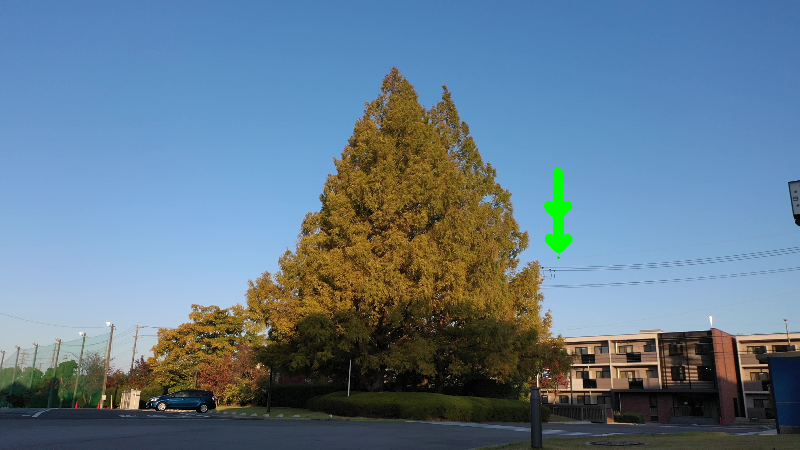

   Scanning frame 40/597...
   📸 Frame 52: ⚠️ DISTRACTION (Predicted wrong object)


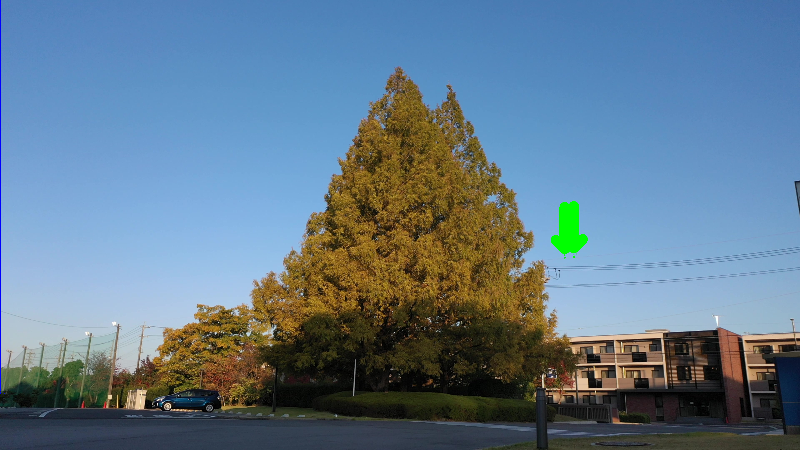

   ✅ Found examples. Moving to next video.


In [ ]:
#@title Visualization
import glob
import os
import cv2
import sys
import numpy as np
from google.colab.patches import cv2_imshow

# Tracker Class (Required for Strategy Viz)
class ObjectTracker:
    def __init__(self, dist_thresh=50, min_hits=3):
        self.tracks = []
        self.track_id_count = 0
        self.dist_thresh = dist_thresh
        self.min_hits = min_hits

    def update(self, detections):
        if len(self.tracks) == 0:
            for det in detections:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1
            return []

        assigned_dets = set()
        for track in self.tracks:
            best_dist = self.dist_thresh
            best_det_idx = -1
            for i, det in enumerate(detections):
                if i in assigned_dets: continue
                # Euclidean distance center-to-center
                cx_t, cy_t = track['box'][0]+track['box'][2]/2, track['box'][1]+track['box'][3]/2
                cx_d, cy_d = det[0]+det[2]/2, det[1]+det[3]/2
                d = ((cx_t-cx_d)**2 + (cy_t-cy_d)**2)**0.5

                if d < best_dist:
                    best_dist = d
                    best_det_idx = i

            if best_det_idx != -1:
                track['box'] = detections[best_det_idx]
                track['hits'] += 1
                track['skipped'] = 0
                assigned_dets.add(best_det_idx)
            else:
                track['skipped'] += 1

        for i, det in enumerate(detections):
            if i not in assigned_dets:
                self.tracks.append({'box': det, 'id': self.track_id_count, 'hits': 1, 'skipped': 0})
                self.track_id_count += 1

        self.tracks = [t for t in self.tracks if t['skipped'] <= 5]
        return [t['box'] for t in self.tracks if t['hits'] >= self.min_hits]

# Helper Functions
def boxes_intersect(boxA, boxB):
    ax1, ay1, ax2, ay2 = boxA[0], boxA[1], boxA[0]+boxA[2], boxA[1]+boxA[3]
    bx1, by1, bx2, by2 = boxB[0], boxB[1], boxB[0]+boxB[2], boxB[1]+boxB[3]
    if (ax1 > bx2) or (ax2 < bx1) or (ay1 > by2) or (ay2 < by1): return False
    return True

def draw_arrow_pointer(img, x, y, w, h, color=(0, 255, 0)):
    center_x = int(x + w // 2)
    gap = 40
    arrow_len = 200
    if y < (gap + arrow_len):
        start_point = (center_x, y + h + gap + arrow_len)
        end_point = (center_x, y + h + gap)
    else:
        start_point = (center_x, y - gap - arrow_len)
        end_point = (center_x, y - gap)
    cv2.arrowedLine(img, start_point, end_point, color, thickness=50, tipLength=0.3)

def align_frames(prev_gray, curr_gray):
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=200, qualityLevel=0.01, minDistance=30)
    if prev_pts is None: return None
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None)
    good_prev = prev_pts[status == 1]
    good_curr = curr_pts[status == 1]
    if len(good_prev) < 4: return None
    H, mask = cv2.findHomography(good_prev, good_curr, cv2.RANSAC, 5.0)
    if H is None: return None
    height, width = prev_gray.shape
    return cv2.warpPerspective(prev_gray, H, (width, height))

def load_json_ground_truth(json_path):
    if not os.path.exists(json_path): return {}
    with open(json_path, 'r') as f: data = json.load(f)
    id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    img_id_to_boxes = {}
    if 'annotations' in data:
        for ann in data['annotations']:
            if ann['image_id'] not in img_id_to_boxes: img_id_to_boxes[ann['image_id']] = []
            img_id_to_boxes[ann['image_id']].append(ann['bbox'])
    filename_to_gt = {}
    for img_id, filename in id_to_filename.items():
        key = filename.replace('train/', '', 1) if filename.startswith('train/') else filename
        filename_to_gt[key] = img_id_to_boxes.get(img_id, [])
    return filename_to_gt

# Main Viz Function
def visualize_strategy_smart_all_videos():
    search_path = os.path.join(TRAIN_DIR, '*')
    video_folders = sorted(glob.glob(search_path))
    video_folders = [f for f in video_folders if os.path.isdir(f)]

    # --- FILTERING LOGIC (MATCHES CELL 2) ---
    if SHOULD_LIMIT_VIDEO:
        if SHOULD_LIMIT_VIDEO == 1:
          print(f"🎯 Limiting Visualization to ONLY Video Indexes: {VIDEO_INDEXES}")
          new_video_folders = []
          for ind in VIDEO_INDEXES:
            new_video_folders.append(video_folders[ind])
          video_folders = new_video_folders
        else:
            print(f"🎯 Limiting Visualization to first {SHOULD_LIMIT_VIDEO} videos.")
            video_folders = video_folders[:min(len(video_folders),SHOULD_LIMIT_VIDEO)]
    # ----------------------------------------

    if not video_folders:
        print(f"❌ No videos found in: {TRAIN_DIR}")
        return

    gt_data = load_json_ground_truth(LOCAL_ANNOTATION_PATH)
    print(f"🕵️ Starting Scan across {len(video_folders)} videos...")

    for v_idx, target_video in enumerate(video_folders):
        video_name = os.path.basename(target_video)
        images = sorted(glob.glob(os.path.join(target_video, '*.jpg')))

        print(f"\n==========================================")
        print(f"🎬 VIDEO {v_idx+1}/{len(video_folders)}: {video_name}")
        print(f"==========================================")

        tracker = ObjectTracker(dist_thresh=50, min_hits=3)
        prev_gray = None
        hit_found = False
        distraction_found = False

        for i, img_path in enumerate(images):
            # Optim: Stop if we found both examples for this video
            if hit_found and distraction_found:
                print("   ✅ Found examples. Moving to next video.")
                break

            if i % 20 == 0:
                sys.stdout.write(f"\r   Scanning frame {i}/{len(images)}...")
                sys.stdout.flush()

            frame = cv2.imread(img_path)
            curr_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # --- RUN PIPELINE ---
            raw_detections = []
            if prev_gray is not None:
                warped_prev = align_frames(prev_gray, curr_gray)
                if warped_prev is not None:
                    diff = cv2.absdiff(curr_gray, warped_prev)
                    _, thresh = cv2.threshold(diff, 50, 255, cv2.THRESH_BINARY)
                    kernel = np.ones((3,3), np.uint8)
                    thresh = cv2.dilate(thresh, kernel, iterations=2)
                    thresh = cv2.erode(thresh, kernel, iterations=1)
                    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                    for cnt in contours:
                        if 50 < cv2.contourArea(cnt) < 3000:
                            raw_detections.append(list(cv2.boundingRect(cnt)))

            prev_gray = curr_gray
            final_preds = tracker.update(raw_detections)

            # --- ANALYZE FRAME ---
            key = f"{video_name}/{os.path.basename(img_path)}"
            gts = gt_data.get(key, [])

            has_overlap = False
            has_separation = False

            if len(gts) > 0 and len(final_preds) > 0:
                overlap_count = 0
                for p in final_preds:
                    for g in gts:
                        if boxes_intersect(p, g):
                            overlap_count += 1
                if overlap_count > 0: has_overlap = True
                else: has_separation = True

            show_it = False
            label = ""

            if has_overlap and not hit_found:
                show_it = True
                hit_found = True
                label = "✅ HIT (Accurate Detection)"

            elif has_separation and not distraction_found:
                show_it = True
                distraction_found = True
                label = "⚠️ DISTRACTION (Predicted wrong object)"

            if show_it:
                print(f"\n   📸 Frame {i}: {label}")

                # 1. Draw Preds (Blue)
                for box in final_preds:
                    x, y, bw, bh = map(int, box)
                    cv2.rectangle(frame, (x, y), (x+bw, y+bh), (255, 0, 0), 2)
                    cv2.putText(frame, "Pred", (x, y+bh+15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

                # 2. Draw GT (Green) + ARROWS
                for box in gts:
                    x, y, bw, bh = map(int, box)
                    cv2.rectangle(frame, (x, y), (x+bw, y+bh), (0, 255, 0), 2)
                    cv2.putText(frame, "GT", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                    draw_arrow_pointer(frame, x, y, bw, bh, color=(0, 255, 0))

                h, w = frame.shape[:2]
                if w > 800: frame = cv2.resize(frame, (800, int(h * 800/w)))
                cv2_imshow(frame)

visualize_strategy_smart_all_videos()